# Introduction
## What we are trying to accomplish
In general we are trying to provide answers to the following questions:
- How is the adoption of renewable energy in Europe evolving?
- How is the adoption of different types of renewable energy evolving?
- Are there characteristics of countries that correlate with their level of adoption of renewable energy?

### Main Questions
As these questions are defined very broadly and can be answered in a variety of ways, we decided to formulate the following more discreet questions, focusing on the production and consumption of renewable energy in europe:
- How has the adoption of renewable energy in Europe developed over time?
- Which types of renewable energy have been predominantly adopted?

### Sub Questions
- How do economic factors like GDP influence the adoption of renewable energy?


## Data Description
We are using the dataset from [Kaggle](https://www.kaggle.com/datasets/programmerrdai/renewable-energy/data). The general description can be found at the original [ourworldindata.org](https://ourworldindata.org/grapher/installed-solar-pv-capacity#:~:text=IRENA%20%E2%80%93%20Renewable%20Capacity-,Statistics) data source.
**Absolute Values:** Absolute measurements are represented in megawatts (MW) rounded to the nearest one megawatt, with figures between zero and 0.5MW shown as a 0.
**Shares:** Shares are represented as percentages

## Exploring the data
Load all required packages and modules

In [367]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The dataset contains a wide range of data from different countries and time ranges. In this exercise we chose to only consider **european** countries and compare them to the overall european and global trends. We take the **years (1990-2020)** into consideration to answer our questions.

In [368]:
# ISO codes for European countries
country_codes = (
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
    'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT',
    'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'GBR')
entities = ('Europe', 'World')
time_window = (1990, 2020)

We clean the data by:
- Handling all NaN by dropping them
- Removing all non-European countries
- Only consider our targeted time window (1990-2020)

In [369]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    #df = df.dropna()

    # Only Use European Countries & Europe/World accumulated data
    df = df[(df['Code'].isin(country_codes)) | (df['Entity'].isin(entities))]
    #df = df[(df['Entity'] == 'Europe')]

    # Only consider data from (1990-2020)
    if 'Year' in df.columns:
        df.loc[:, 'Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df = df[(df['Year'] >= time_window[0]) & (df['Year'] <= time_window[1])]

    df.reset_index(drop=True, inplace=True)

    return df

Put it all together and read and clean the dataframes:

In [370]:
def read_and_clean_csv(file) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = clean_df(df)
    return df

folder_path = os.path.join('..', 'data')
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

dataframes = {os.path.basename(file).split('.')[0]: clean_df(read_and_clean_csv(file)) for file in csv_files}

### Merge semantically relevant dataframes
Now we merge dataframes that contain semantically relevant data into one. These are:
- `share_energy:` merged from `hydro-share-energy`,`solar-share-energy`,`wind-share-energy`,`renewable-share-energy`
- `share_electricity:` merged from `share-electricity-hydro`,`share-electricity-solar`,`share-electricity-solar`,`share-electricity-wind`,`share-electricity-renewables`



In [371]:
def merge_share_dfs(dfs: dict[str: pd.DataFrame], sub_str: str) -> pd.DataFrame:
    relevant_keys = [key for key in dfs.keys() if sub_str in key]
    filtered_dfs = dfs[relevant_keys[0]]
    for key in relevant_keys[1:]:
        filtered_dfs = filtered_dfs.merge(
            dfs[key],
            on=['Entity', 'Code', 'Year'],
            how='outer',
        )
    return filtered_dfs

share_energy_long = merge_share_dfs(dataframes, 'share-energy')
share_electricity_long = merge_share_dfs(dataframes, 'share-electricity')

Add 'Other Renewables' Column

In [372]:
share_energy_long['Other Renewables (% sub energy)'] = share_energy_long['Renewables (% sub energy)'] - ((share_energy_long['Solar (% sub energy)']) + (share_energy_long['Hydro (% sub energy)']) + (share_energy_long['Wind (% sub energy)']))
share_electricity_long['Other Renewables (% electricity)'] = share_electricity_long['Renewables (% electricity)'] - ((share_electricity_long['Solar (% electricity)']) + (share_electricity_long['Hydro (% electricity)']) + (share_electricity_long['Wind (% electricity)']))

### Multi-Index
These newly merged frames can now be converted from a long format to a wide multi-index dataformat.

In [373]:
share_energy = share_energy_long.set_index(['Entity','Code', 'Year'])
share_electricity = share_electricity_long.set_index(['Entity','Code', 'Year'])

### Check the Data

In [374]:
print("Merged 'share_energy' DataFrame:")
display(share_energy)

print("\nMerged 'share_electricity' DataFrame:")
display(share_electricity)

Merged 'share_energy' DataFrame:


Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Code     Year                                                    
Austria AUT      1990                26.600                     27.586   
                 1991                25.290                     26.299   
                 1992                28.540                     29.655   
                 1993                29.555                     30.682   
                 1994                28.912                     29.914   
...                                     ...                        ...   
World   OWID_WRL 2016                 6.594                     10.239   
                 2017                 6.515                     10.618   
                 2018                 6.486                     10.978   
                 2019                 6.481                     11.437   
                 2020                 6.856                     12.553   

                       Solar (% sub energy)  Wind (% sub energy)  \
Entity  Code     Year                                              
Austria AUT      1990                 0.000                0.000   
                 1991                 0.000                0.000   
                 1992                 0.000                0.000   
                 1993                 0.001                0.000   
                 1994                 0.001                0.000   
...                                     ...                  ...   
World   OWID_WRL 2016                 0.539                1.579   
                 2017                 0.715                1.827   
                 2018                 0.896                1.972   
                 2019                 1.085                2.174   
                 2020                 1.365                2.539   

                       Other Renewables (% sub energy)  
Entity  Code     Year                                   
Austria AUT      1990                            0.986  
                 1991                            1.009  
                 1992                            1.115  
                 1993                            1.126  
                 1994                            1.001  
...                                                ...  
World   OWID_WRL 2016                            1.527  
                 2017                            1.561  
                 2018                            1.624  
                 2019                            1.697  
                 2020                            1.793  

[992 rows x 5 columns]


Merged 'share_electricity' DataFrame:


Hydro (% electricity)  Renewables (% electricity)  \
Entity  Code     Year                                                      
Austria AUT      1990                 63.915                      66.207   
                 1991                 62.654                      65.066   
                 1992                 69.770                      72.392   
                 1993                 71.462                      74.070   
                 1994                 68.528                      70.812   
...                                      ...                         ...   
World   OWID_WRL 2016                 16.531                      24.256   
                 2017                 16.277                      25.076   
                 2018                 16.129                      25.763   
                 2019                 16.048                      26.711   
                 2020                 16.516                      28.522   

                       Solar (% electricity)  Wind (% electricity)  \
Entity  Code     Year                                                
Austria AUT      1990                  0.000                 0.000   
                 1991                  0.000                 0.000   
                 1992                  0.000                 0.000   
                 1993                  0.000                 0.000   
                 1994                  0.000                 0.000   
...                                      ...                   ...   
World   OWID_WRL 2016                  1.358                 3.965   
                 2017                  1.782                 4.570   
                 2018                  2.196                 4.906   
                 2019                  2.642                 5.401   
                 2020                  3.197                 6.079   

                       Other Renewables (% electricity)  
Entity  Code     Year                                    
Austria AUT      1990                             2.292  
                 1991                             2.412  
                 1992                             2.622  
                 1993                             2.608  
                 1994                             2.284  
...                                                 ...  
World   OWID_WRL 2016                             2.402  
                 2017                             2.447  
                 2018                             2.532  
                 2019                             2.620  
                 2020                             2.730  

[1023 rows x 5 columns]

### Noticing Trends
Now let's create some plots in order to better observe certain trends

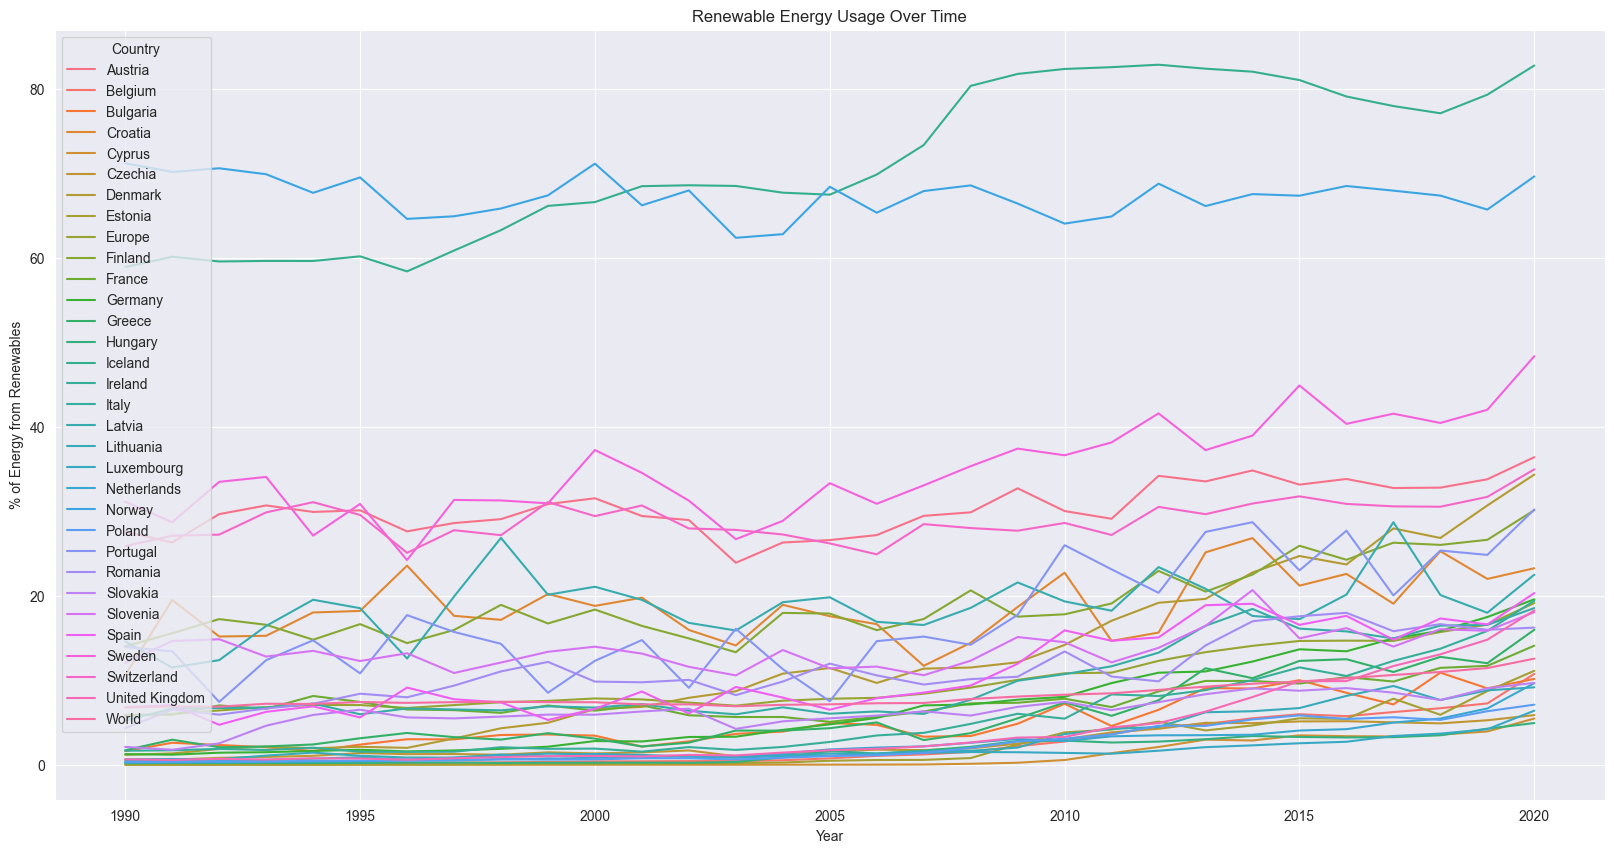

In [375]:
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Plot renewables over time for selected countries
plt.figure(figsize=(20, 10))
sns.lineplot(data=data_filtered, x='Year', y='Renewables (% sub energy)', hue='Entity')
plt.title('Renewable Energy Usage Over Time')
plt.ylabel('% of Energy from Renewables')
plt.xlabel('Year')
plt.legend(title='Country')
plt.grid(True)
plt.show()

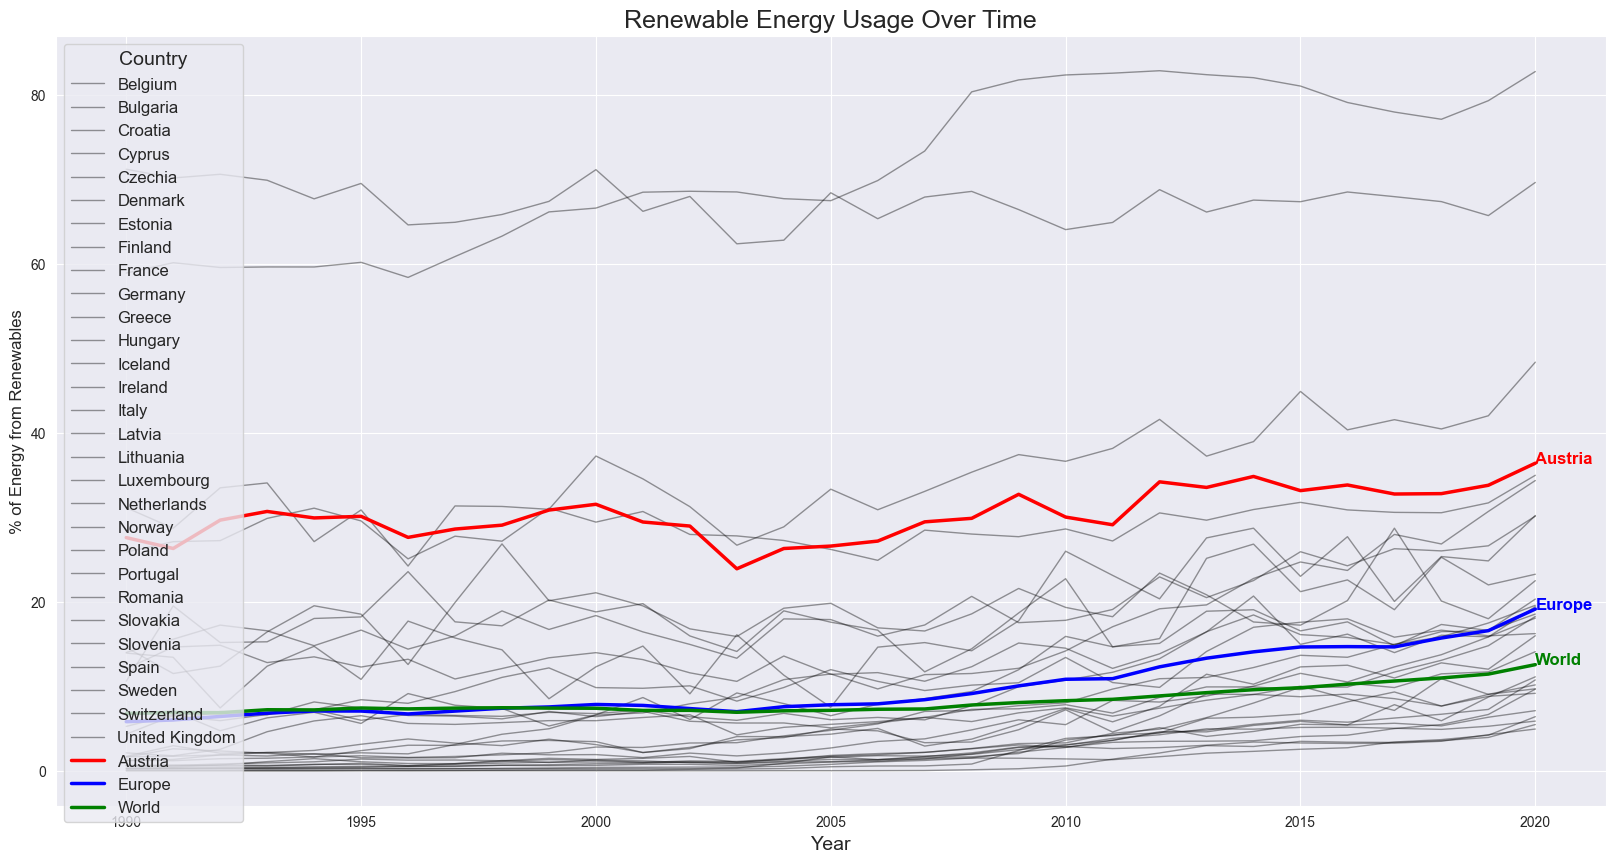

In [376]:
# Filter data for specific countries
countries = ['Austria', 'Belgium', 'Czechia', 'Europe', 'France', 'Germany', 'Spain', 'Norway', 'Romania', 'United Kingdom', 'World']
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Define standout countries
standout_countries = ['Austria', 'Europe', 'World']

# Create a custom color palette
palette = {country: 'black' for country in data_filtered['Entity'].unique()}
palette.update({
    'Austria': 'red',
    'Europe': 'blue',
    'World': 'green'
})

# Plot
plt.figure(figsize=(20, 10))

# Plot all countries with lighter lines
sns.lineplot(
    data=data_filtered[~data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, alpha=0.4, linewidth=1
)

# Plot standout countries with distinctive styles
sns.lineplot(
    data=data_filtered[data_filtered['Entity'].isin(standout_countries)],
    x='Year', y='Renewables (% sub energy)',
    hue='Entity', palette=palette, linewidth=2.5
)

# Add titles and labels
plt.title('Renewable Energy Usage Over Time', fontsize=18)
plt.ylabel('% of Energy from Renewables', fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.legend(title='Country', fontsize=12, title_fontsize=14)
plt.grid(True)

# Highlight lines with direct annotations
for country in standout_countries:
    country_data = data_filtered[data_filtered['Entity'] == country]
    plt.text(
        country_data['Year'].iloc[-1],
        country_data['Renewables (% sub energy)'].iloc[-1],
        country,
        color=palette[country], fontsize=12, weight='bold'
    )

plt.show()

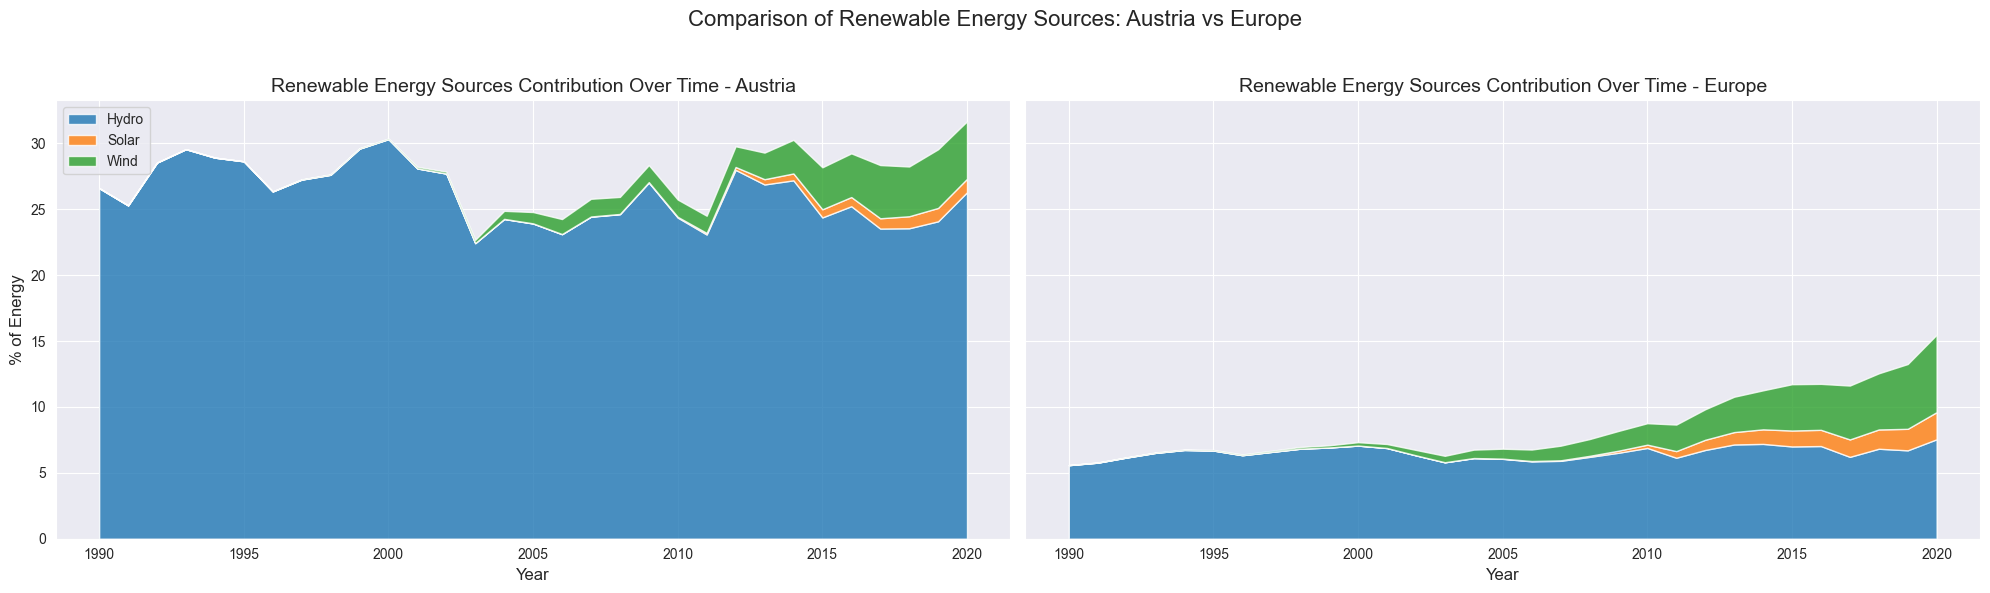

In [377]:
# Select data for Austria
country_austria = 'Austria'
data_austria = share_energy.loc[country_austria].reset_index()

# Select data for Europe
country_europe = 'Europe'
data_europe = share_energy.loc[country_europe].reset_index()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot for Austria
axes[0].stackplot(
    data_austria['Year'],
    data_austria['Hydro (% sub energy)'],
    data_austria['Solar (% sub energy)'],
    data_austria['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[0].set_title(f'Renewable Energy Sources Contribution Over Time - {country_austria}', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('% of Energy', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# Plot for Europe
axes[1].stackplot(
    data_europe['Year'],
    data_europe['Hydro (% sub energy)'],
    data_europe['Solar (% sub energy)'],
    data_europe['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
axes[1].set_title(f'Renewable Energy Sources Contribution Over Time - {country_europe}', fontsize=14)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].grid(True)

# Adjust layout
plt.suptitle('Comparison of Renewable Energy Sources: Austria vs Europe', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [378]:
print(share_energy.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 992 entries, ('Austria', 'AUT', np.int64(1990)) to ('World', 'OWID_WRL', np.int64(2020))
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Hydro (% sub energy)             992 non-null    float64
 1   Renewables (% sub energy)        992 non-null    float64
 2   Solar (% sub energy)             992 non-null    float64
 3   Wind (% sub energy)              992 non-null    float64
 4   Other Renewables (% sub energy)  992 non-null    float64
dtypes: float64(5)
memory usage: 45.7+ KB
None


Even though we only have specific data for Hydro, Solar and Wing generation, there other renewable ways of generating energy. To show how much data we are missing on other renewable energy types, we plotted the most recent (2020) energy usage.

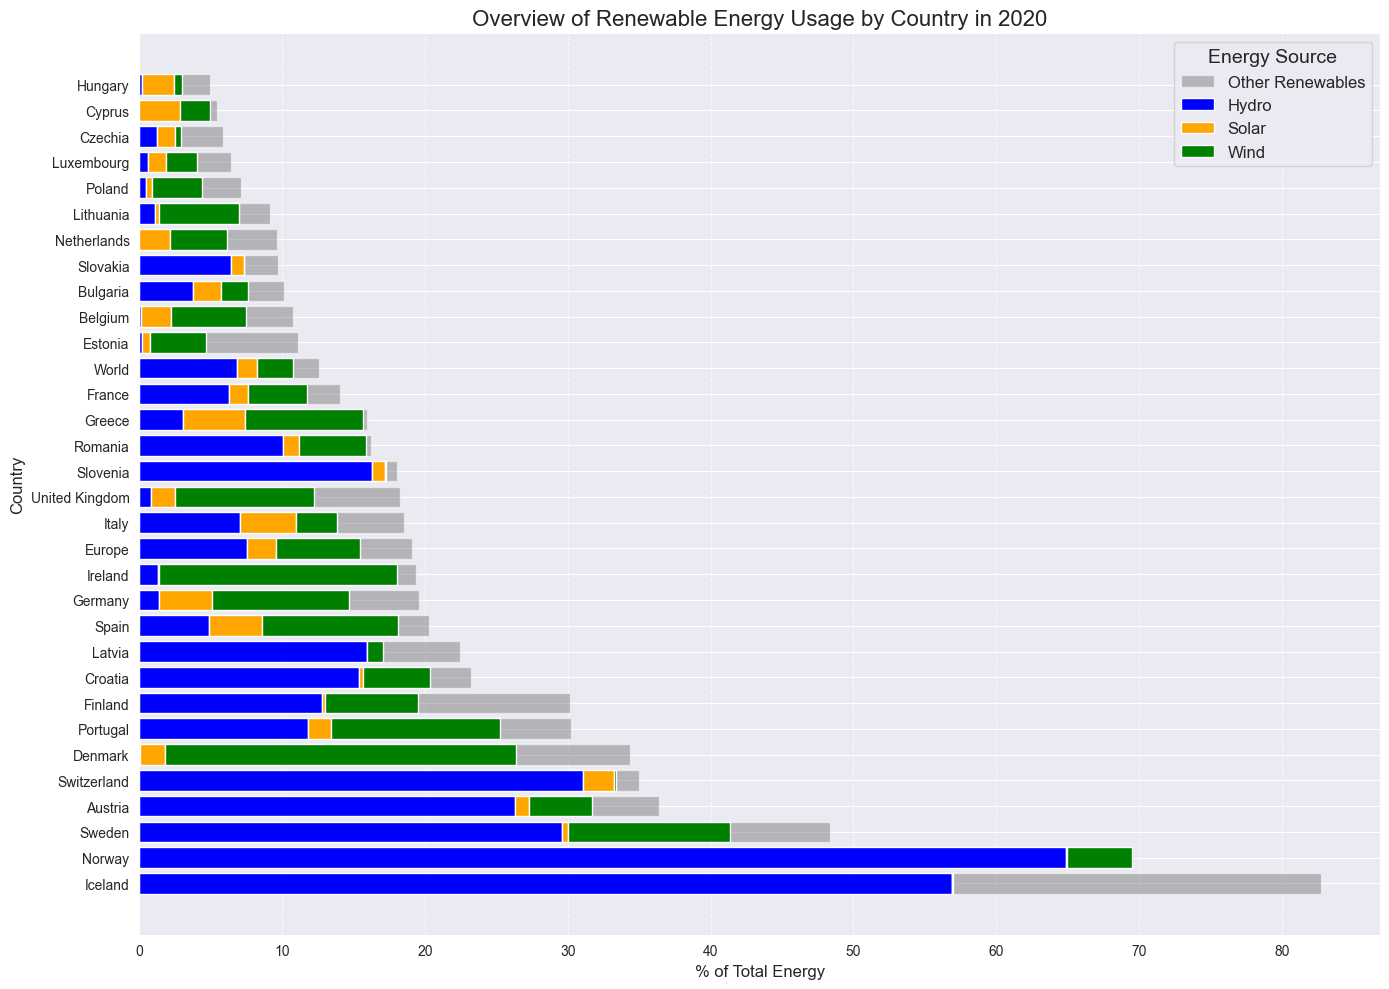

In [379]:
# Filter the data for the year 2020
data_2020 = share_energy.xs(key=2020, level='Year')

# Sort by total renewables for better visualization
data_2020 = data_2020.sort_values(by='Renewables (% sub energy)', ascending=False)

# Create a stacked bar plot
plt.figure(figsize=(14, 10))

# Plot the total renewable energy as a separate bar beforehand
# This makes it show up as the other types of renewable energy that we are missing (e.g. not in hydro, wind, solar)
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Renewables (% sub energy)'], label='Other Renewables', color='gray', alpha=0.5)

# Plot the stacked bars for Hydro, Solar, and Wind
plt.barh(data_2020.index.get_level_values('Entity'), data_2020['Hydro (% sub energy)'], label='Hydro', color='blue')
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Solar (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'],
    label='Solar',
    color='orange'
)
plt.barh(
    data_2020.index.get_level_values('Entity'),
    data_2020['Wind (% sub energy)'],
    left=data_2020['Hydro (% sub energy)'] + data_2020['Solar (% sub energy)'],
    label='Wind',
    color='green'
)

# Add labels and title
plt.title('Overview of Renewable Energy Usage by Country in 2020', fontsize=16)
plt.xlabel('% of Total Energy', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Energy Source', fontsize=12, title_fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Interesting statistics and relations
## Relation between energy and electricity

In [380]:
share_energy_electricity = pd.merge(
    share_energy,
    share_electricity,
    left_index=True,
    right_index=True,
    how='inner'
)
display(share_energy_electricity)

Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Code     Year                                                    
Austria AUT      1990                26.600                     27.586   
                 1991                25.290                     26.299   
                 1992                28.540                     29.655   
                 1993                29.555                     30.682   
                 1994                28.912                     29.914   
...                                     ...                        ...   
World   OWID_WRL 2016                 6.594                     10.239   
                 2017                 6.515                     10.618   
                 2018                 6.486                     10.978   
                 2019                 6.481                     11.437   
                 2020                 6.856                     12.553   

                       Solar (% sub energy)  Wind (% sub energy)  \
Entity  Code     Year                                              
Austria AUT      1990                 0.000                0.000   
                 1991                 0.000                0.000   
                 1992                 0.000                0.000   
                 1993                 0.001                0.000   
                 1994                 0.001                0.000   
...                                     ...                  ...   
World   OWID_WRL 2016                 0.539                1.579   
                 2017                 0.715                1.827   
                 2018                 0.896                1.972   
                 2019                 1.085                2.174   
                 2020                 1.365                2.539   

                       Other Renewables (% sub energy)  Hydro (% electricity)  \
Entity  Code     Year                                                           
Austria AUT      1990                            0.986                 63.915   
                 1991                            1.009                 62.654   
                 1992                            1.115                 69.770   
                 1993                            1.126                 71.462   
                 1994                            1.001                 68.528   
...                                                ...                    ...   
World   OWID_WRL 2016                            1.527                 16.531   
                 2017                            1.561                 16.277   
                 2018                            1.624                 16.129   
                 2019                            1.697                 16.048   
                 2020                            1.793                 16.516   

                       Renewables (% electricity)  Solar (% electricity)  \
Entity  Code     Year                                                      
Austria AUT      1990                      66.207                  0.000   
                 1991                      65.066                  0.000   
                 1992                      72.392                  0.000   
                 1993                      74.070                  0.000   
                 1994                      70.812                  0.000   
...                                           ...                    ...   
World   OWID_WRL 2016                      24.256                  1.358   
                 2017                      25.076                  1.782   
                 2018                      25.763                  2.196   
                 2019                      26.711                  2.642   
                 2020                      28.522                  3.197   

                       Wind (% electricity)  Other Renewables (% electricity)  
Entity  Code     Year                               

Let's examine correlations between renewable energy and renewable electricity.

In [381]:
correlation = share_energy_electricity[['Renewables (% sub energy)', 'Renewables (% electricity)']].corr()
print("Correlation between renewable energy and renewable electricity:")
print(correlation)

Correlation between renewable energy and renewable electricity:
                            Renewables (% sub energy)  \
Renewables (% sub energy)                    1.000000   
Renewables (% electricity)                   0.915113   

                            Renewables (% electricity)  
Renewables (% sub energy)                     0.915113  
Renewables (% electricity)                    1.000000  


Identify countries with the largest gaps between renewable energy and electricity in 2020.

### Visualizations

In [382]:
# Bar plot for largest gaps
plt.figure(figsize=(12, 6))
sns.barplot(data=largest_gaps.head(10), x='Gap', y='Country', palette='coolwarm')
plt.title('Top 10 Countries with Largest Gaps (Renewables: Electricity vs Energy) - 2020', fontsize=16)
plt.xlabel('Gap (% Electricity - % Energy)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.grid(True)
plt.show()


NameError: name 'largest_gaps' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Line plot for trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=europe_world,
    x='Year',
    y='Renewables (% sub energy)',
    hue='Country',
    style='Country',
    markers=True,
    label='Renewables (% sub energy)'
)
sns.lineplot(
    data=europe_world,
    x='Year',
    y='Renewables (% electricity)',
    hue='Country',
    style='Country',
    dashes=True,
    label='Renewables (% electricity)'
)
plt.title('Renewable Energy vs Electricity Trends (Europe & World)', fontsize=16)
plt.ylabel('% Renewables', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Legend')
plt.grid(True)
plt.show()

In [ ]:
# Filter 2020 data
sources_2020 = data_2020[['Country', 'Hydro (% sub energy)', 'Solar (% sub energy)', 'Wind (% sub energy)',
                          'Hydro (% electricity)', 'Solar (% electricity)', 'Wind (% electricity)']]

# Melt for easier plotting
melted = sources_2020.melt(id_vars='Country', var_name='Source', value_name='Percentage')

# Separate energy and electricity data
melted['Type'] = melted['Source'].apply(lambda x: 'Energy' if 'energy' in x else 'Electricity')
melted['Source'] = melted['Source'].str.replace(' (% sub energy)', '').str.replace(' (% electricity)', '')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=melted, x='Percentage', y='Country', hue='Type', palette='muted')
plt.title('Renewable Energy vs Electricity Breakdown by Source - 2020', fontsize=16)
plt.xlabel('% Contribution', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Type')
plt.grid(True)
plt.show()


In [279]:
# Optionally, print the cleaned data for verification
for key, df in dataframes.items():
    print(f'{key}:')
    print(df.head(), '\n')

biofuel-production:
    Entity Code  Year  Biofuels Production - TWh - Total
0  Austria  AUT  1990                           0.073269
1  Austria  AUT  1991                           0.080247
2  Austria  AUT  1992                           0.089551
3  Austria  AUT  1993                           0.101181
4  Austria  AUT  1994                           0.067454 

cumulative-installed-wind-energy-capacity-gigawatts:
    Entity Code  Year  Wind Capacity
0  Austria  AUT  1997          0.020
1  Austria  AUT  1998          0.030
2  Austria  AUT  1999          0.042
3  Austria  AUT  2000          0.050
4  Austria  AUT  2001          0.067 

hydro-share-energy:
    Entity Code  Year  Hydro (% sub energy)
0  Austria  AUT  1990                26.600
1  Austria  AUT  1991                25.290
2  Austria  AUT  1992                28.540
3  Austria  AUT  1993                29.555
4  Austria  AUT  1994                28.912 

hydropower-consumption:
    Entity Code  Year  Electricity from hydro (TW